# **Analysis of the Top 40 Streamed Songs of 2020**

##### By: Gianna Barletta, Sophie Lefebvre, Grace Michael, Preston Reep & Dachuan Zhang


Mounting Drive

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Changing directory
%cd /content/drive/My Drive/DS2500 Project

/content/drive/My Drive/DS2500 Project


In [ ]:
%pwd

'/content/drive/My Drive/DS2500 Project'

# Importing Data

In [ ]:
import pandas as pd
import re
from pathlib import Path
import wordcloud as wc
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import imageio
from collections import Counter
import os
import numpy as np
from sklearn.linear_model import LinearRegression


pd.set_option('display.max_columns', None)

In [ ]:
def read_file(filename):
  return pd.read_csv(r'/content/drive/My Drive/DS2500 Project/'+ filename)

In [ ]:
def clean_df(x, column1, column2):
  """ Cleans the text in the specified columns of the dataframe, x """

  x[column1] = [word.lower() for word in x[column1]]
  x[column2] = [word.lower() for word in x[column2]]
  x[column1] = [re.sub('[^\w\s]','',word) for word in x[column1]]
  x[column1] = [re.sub(' {2,}', ' ', word) for word in x[column1]]
  x[column2] = [re.sub('[^\w\s]','',word) for word in x[column2]]
  x[column2] = [re.sub(' {2,}', ' ', word) for word in x[column2]]
  x['key'] = x[column1] + " " + x[column2]

  return x

In [ ]:
# import the list of top 40 songs
songs = read_file('top_40.csv')
songs = clean_df(songs, 'TITLE', 'ARTIST')
songs['original_rank'] = songs.index # preserves the song ranking in case future changes mess up the index

In [ ]:
# import the data from Spotify on song attributes
song_data = read_file('data.csv')
''' we need to remove punctuation for the artist name so that we can merge it with the Top 40 list without issues
    but that no longer differentiates between multiple artists on the same song, which we need for our analysis on 
    single artist vs. multiple. we create an extra column for that analysis
'''
song_data['artist_duplicate'] = song_data['artists']
song_data = clean_df(song_data, 'name', 'artists')
song_data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artist_duplicate
0,0.991000,mamie smith,0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,keep a song in your soul mamie smith,0.3790,-12.628,0,keep a song in your soul,12,1920,0.0936,149.976,0.6340,1920,['Mamie Smith']
1,0.643000,screamin jay hawkins,0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,i put a spell on you screamin jay hawkins,0.0809,-7.261,0,i put a spell on you,7,1920-01-05,0.0534,86.889,0.9500,1920,"[""Screamin' Jay Hawkins""]"
2,0.993000,mamie smith,0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,golfing papa mamie smith,0.5190,-12.098,1,golfing papa,4,1920,0.1740,97.600,0.6890,1920,['Mamie Smith']
3,0.000173,oscar velazquez,0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,true house music xavier santos carlos gomix re...,0.1280,-7.311,1,true house music xavier santos carlos gomix remix,17,1920-01-01,0.0425,127.997,0.0422,1920,['Oscar Velazquez']
4,0.295000,mixe,0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,xuniverxe mixe,0.4020,-6.036,0,xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920,['Mixe']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.009170,dj combo sander7 tony t,0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,the one dj combo sander7 tony t,0.1780,-5.089,0,the one,0,2020-12-25,0.0356,125.972,0.1860,2020,"['DJ Combo', 'Sander-7', 'Tony T']"
174385,0.795000,alessia cara,0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,a little more alessia cara,0.1960,-11.665,1,a little more,0,2021-01-22,0.0360,94.710,0.2280,2021,['Alessia Cara']
174386,0.806000,roger fly,0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,together roger fly,0.1130,-12.393,0,together,0,2020-12-09,0.0282,108.058,0.7140,2020,['Roger Fly']
174387,0.920000,taylor swift,0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,champagne problems taylor swift,0.1130,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.3200,2021,['Taylor Swift']


In [ ]:
# combines the two dataframes so we have the song attributes for just the songs we are analyzing
combined = songs.merge(song_data,how = 'inner', on = "key")
combined = combined.drop(columns=['id','mode','name','artists'])

In [ ]:
''' there are multiple versions for some songs - e.g. an artist might release a song as a single
    but then release it again on their album. it's the same song but Spotify will view it as 2 different
    songs. this drops the duplicates and keeps the first version of the song released so we can use the
    accurate release date in our analysis
'''
combined = combined.sort_values(by=['TITLE','release_date'])
combined.drop_duplicates(subset ="key", keep = "first", inplace = True)

combined.reset_index(drop = True)

,TITLE,ARTIST,PEAK,key,original_rank,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,release_date,speechiness,tempo,valence,year,artist_duplicate
0,adore you,harry styles,7,adore you harry styles,18,0.0237,0.676,207133,0.771,0,0.000007,0.1020,-3.675,75,2019-12-06,0.0483,99.048,0.569,2019,['Harry Styles']
1,baby shark,pinkfong,6,baby shark pinkfong,25,0.2590,0.829,80927,0.886,0,0.000000,0.0559,-1.746,76,2017-07-27,0.1120,115.056,0.777,2017,['Pinkfong']
2,bad guy,billie eilish,2,bad guy billie eilish,29,0.3280,0.701,194088,0.425,0,0.130000,0.1000,-10.965,87,2019-03-29,0.3750,135.128,0.562,2019,['Billie Eilish']
3,before you go,lewis capaldi,1,before you go lewis capaldi,4,0.6040,0.459,215107,0.575,0,0.000000,0.0885,-4.858,84,2019-11-19,0.0573,111.881,0.183,2019,['Lewis Capaldi']
4,blueberry faygo,lil mosey,9,blueberry faygo lil mosey,28,0.2070,0.774,162547,0.554,1,0.000000,0.1320,-7.909,83,2020-02-06,0.0383,99.034,0.349,2020,['Lil Mosey']
5,breaking me,topic a7s,3,breaking me topic a7s,20,0.2230,0.789,166794,0.720,0,0.000000,0.1290,-5.652,89,2019-12-19,0.2180,122.031,0.664,2019,"['Topic', 'A7S']"
6,bruises,lewis capaldi,6,bruises lewis capaldi,24,0.9460,0.736,220492,0.308,0,0.000000,0.1860,-7.830,83,2019-05-17,0.0677,111.202,0.361,2019,['Lewis Capaldi']
7,dance monkey,tones and i,1,dance monkey tones and i,1,0.6920,0.824,209438,0.588,0,0.000104,0.1490,-6.400,89,2019-10-17,0.0924,98.027,0.513,2019,['Tones And I']
8,death bed coffee for your head,powfu beabadoobee,4,death bed coffee for your head powfu beabadoobee,22,0.7310,0.726,173333,0.431,0,0.000000,0.6960,-8.765,89,2020-02-08,0.1350,144.026,0.348,2020,"['Powfu', 'beabadoobee']"
9,dont start now,dua lipa,2,dont start now dua lipa,6,0.0125,0.794,183290,0.793,0,0.000000,0.0952,-4.521,85,2019-10-31,0.0842,123.941,0.677,2019,['Dua Lipa']


In [ ]:
# missing songs:
# blinding lights, own it, lonely, rover, rain, flowers

# Part 1: Analyzing Song Information

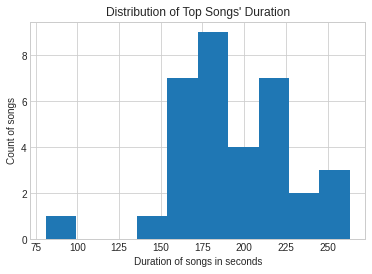

In [ ]:
import matplotlib.pyplot as plt

def duration(df, column, bins = 10):
  """ Visualizing the distribution of top songs' duration in seconds """
  
  df["duration_second"] = df[column] * 0.001
  plt.hist(df["duration_second"])
  plt.xlabel("Duration of songs in seconds")
  plt.ylabel("Count of songs")
  plt.title("Distribution of Top Songs' Duration")

duration(combined, "duration_ms")

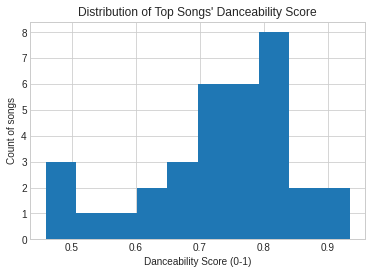

In [ ]:
def danceability(df, column, bins = 10):
  """ Visualizing the distribution of top songs' duration on a scale of 0-1 """

  plt.hist(df[column], bins = bins)
  plt.xlabel("Danceability Score (0-1)")
  plt.ylabel("Count of songs")
  plt.title("Distribution of Top Songs' Danceability Score")

danceability(combined, "danceability")


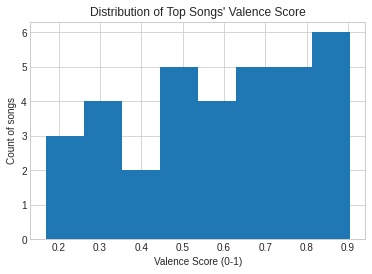

In [ ]:
def valence(df, column, bins = 8):
  """ Visualizing the distribution of top songs' valence on a scale of 0-1 """

  plt.hist(df[column], bins = bins)
  plt.xlabel("Valence Score (0-1)")
  plt.ylabel("Count of songs")
  plt.title("Distribution of Top Songs' Valence Score")

valence(combined, "valence")

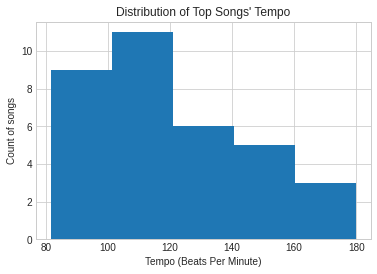

In [ ]:
def tempo(df, column, bins = 5):
  """ Visualizing the distribution of top songs' tempo in beats per minute """

  plt.hist(df[column], bins = bins)
  plt.xlabel("Tempo (Beats Per Minute)")
  plt.ylabel("Count of songs")
  plt.title("Distribution of Top Songs' Tempo")

tempo(combined, "tempo")

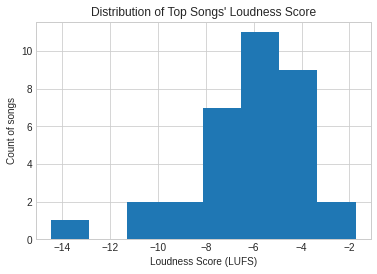

In [ ]:
def loudness(df, column, bins = 8):
  """ Visualizing the distribution of top songs' loudness """

  plt.hist(df[column], bins = bins)
  plt.xlabel("Loudness Score (LUFS)")
  plt.ylabel("Count of songs")
  plt.title("Distribution of Top Songs' Loudness Score")

loudness(combined, "loudness")

In [ ]:
def statistics(df, column):
  """ Find the zscore of a column given the dataset """

  z_scores = []
  series = df[column]
  standard_deviation = df[column].std()
  mean = df[column].mean()
  for index, value in series.items():
    zscore = (value - mean)/ standard_deviation
    z_scores.append(zscore)
  return z_scores

print(statistics(combined, "duration_ms"))

[0.4358058070157929, -3.125986896107266, 0.06764909646130028, 0.6608484754681904, -0.8225027477394857, -0.7026436791519096, 0.8128242429144106, 0.5008576443349271, -0.5180996599632681, -0.23709265597775006, 1.5165129681705025, 0.5392960835664502, -0.7242617734627368, 0.7974432228107542, 0.5976875158498727, 1.299457141349912, -0.06222880173507958, -1.4439806260929149, 0.6107825494794077, 2.023776188983569, 0.06033958415515895, -0.26785469618506297, -0.9619479226608922, -0.2810343959803062, -0.5102539286076415, -0.7917689295874089, -1.0214682371537573, -0.5733584441154871, 1.3039162260772106, -0.2689553563392696, 0.14003866814181187, 1.5625995843709999, -0.1171206991692297, -0.4992755491208115]


In [ ]:
def ranking_most_generic(df, columns):
  """ Find which song had the sum of its z scores closest to 0 """
  values = []
  totals = []
  for item in columns:
    z_scores = statistics(df, item)
    values.append(z_scores)
  for i in range(len(values[0])):
    for lists in values:
      total = 0
      total += abs(lists[i])
    totals.append(total)
  return totals

In [ ]:
z_scores = statistics(combined, 'duration_ms')

#Find Rankings
overall_rankings = ranking_most_generic(combined, ['duration_ms', 'energy', 'danceability', 'tempo', 'loudness'])

#Sort in order of ranking an add a new column for the new ranking
ranking = combined.copy()
ranking['generic'] = overall_rankings
ranking = ranking.sort_values(by = 'generic')
ranking = ranking.reset_index(drop = True)
ranking.reset_index(inplace=True)
ranking = ranking.rename(columns = {'index':'new_rank','TITLE':'song_title'})

In [ ]:
ranking

,new_rank,song_title,ARTIST,PEAK,key,original_rank,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,release_date,speechiness,tempo,valence,year,artist_duplicate,duration_second,generic
0,0,perfect,ed sheeran,1,perfect ed sheeran,39,0.1630,0.599,263400,0.448,0,0.000000,0.1060,-6.312,86,2017-03-03,0.0232,95.050,0.168,2017,['Ed Sheeran'],263.400,0.048754
1,1,mood swings feat lil tjay,pop smoke lil tjay,5,mood swings feat lil tjay pop smoke lil tjay,34,0.4870,0.480,213333,0.602,1,0.000000,0.0848,-6.335,87,2020-07-03,0.3680,179.798,0.269,2020,"['Pop Smoke', 'Lil Tjay']",213.333,0.058085
2,2,dance monkey,tones and i,1,dance monkey tones and i,1,0.6920,0.824,209438,0.588,0,0.000104,0.1490,-6.400,89,2019-10-17,0.0924,98.027,0.513,2019,['Tones And I'],209.438,0.084455
3,3,roses,saint jhn,1,roses saint jhn,2,0.3420,0.782,173611,0.500,1,0.000019,0.1330,-6.473,69,2018-03-30,0.0611,102.008,0.280,2018,['SAINt JHN'],173.611,0.114070
4,4,life is good feat drake,future drake,3,life is good feat drake future drake,9,0.0706,0.676,237735,0.609,1,0.000000,0.1520,-5.831,85,2020-01-10,0.4810,142.037,0.508,2020,"['Future', 'Drake']",237.735,0.146382
5,5,intentions,justin bieber quavo,8,intentions justin bieber quavo,33,0.3170,0.811,212869,0.553,0,0.000000,0.1050,-6.644,80,2020-02-07,0.0552,148.014,0.860,2020,"['Justin Bieber', 'Quavo']",212.869,0.183443
6,6,the box,roddy ricch,2,the box roddy ricch,8,0.1040,0.896,196653,0.586,1,0.000000,0.7900,-6.687,89,2019-12-06,0.0559,116.971,0.642,2019,['Roddy Ricch'],196.653,0.200888
7,7,someone you loved,lewis capaldi,1,someone you loved lewis capaldi,7,0.7510,0.501,182161,0.405,0,0.000000,0.1050,-5.679,80,2018-11-08,0.0319,109.891,0.446,2018,['Lewis Capaldi'],182.161,0.208047
8,8,breaking me,topic a7s,3,breaking me topic a7s,20,0.2230,0.789,166794,0.720,0,0.000000,0.1290,-5.652,89,2019-12-19,0.2180,122.031,0.664,2019,"['Topic', 'A7S']",166.794,0.219001
9,9,roxanne,arizona zervas,4,roxanne arizona zervas,30,0.0522,0.621,163636,0.601,1,0.000000,0.4600,-5.616,86,2019-10-10,0.1480,116.735,0.457,2019,['Arizona Zervas'],163.636,0.233605


In [ ]:
winner = ranking.iloc[0][1]
artist = ranking.iloc[0][2]

print("The song that should be the most successful based on our attribute analysis is:", winner, "by", artist, ".")

The song that should be the most successful based on our attribute analysis is: perfect by ed sheeran .


# Part 2: Reading and Analyzing Lyrics

### Reading and Cleaning Lyrics Data




In [ ]:
def read_song(filename):
    """ Reads contents of the lyric files as a list """
    data_folder = Path('/content/drive/My Drive/DS2500 Project/lyrics')
    file_to_open = data_folder / filename
    with open(file_to_open) as infile:
        lyrics = infile.readlines()
        return lyrics

In [ ]:
def loop_thru_files(directory_in_str):
  ''' loops through all files in a folder, reads in contents of those files, and adds it to a dictionary
    where the filename is the key and the contents of the file is the value
  '''
  directory = os.fsencode(directory_in_str)
  dict = {}
    
  # For each file in the folder, make the filename a dictionary key
  # and the file contents a dictionary value
  for file in os.listdir(directory):
        filename = os.fsdecode(file)
        dict_name = filename.split('.')[0] # removes the file ending eg 'adore_you.txt' becomes 'adore_you'
        dict[dict_name] = read_song(filename)
    
  return dict

In [ ]:
def clean_text(lyrics):
    ''' Inputs a list of strings, removes punctuation, new line characters, and turns words lower case as a list of strings '''
    clean_lyrics = []
    for line in lyrics:
        line = re.sub("[^\w\s]", "", line)
        line = line.lower()
        line = line.replace("\n", "")
        
        clean_line = [word for word in line.split(" ")]
             
        if clean_line != [""]:
            clean_string = " ".join(clean_line)
            clean_lyrics.append(clean_string)
            
    return clean_lyrics  

In [ ]:
# creates a dictionary of our lyrics files
lyrics_dict = loop_thru_files('/content/drive/My Drive/DS2500 Project/lyrics')

In [ ]:
# creates a dictionary of cleaned lyrics so we can run functions on the cleaned version
cleaned_lyrics = {re.sub('_',' ', song[0]): clean_text(song[1]) for song in lyrics_dict.items()}

In [ ]:
# list of explicit words so we can analyze them or remove them
explicits = read_song('/content/drive/My Drive/DS2500 Project/explicits.txt')
explicits = clean_text(explicits)

In [ ]:
# list of stop words removed from songs
stop_words =["a", "an", "and", "the", "to", "i", "if", "of", "that", "it",
            "is", "im", "has", "was", "his", "ive", "at", "in", "your", "its",
            "for", "this", "we", "but", "by", "are", "our", "as", "you"]

In [ ]:
def remove_words(cleaned_lyrics, word_list):
  ''' Removes words in inputted word_list from lyrics list;
      Can remove stop words and/or explicits '''

  lyrics_no_words = []

  for line in cleaned_lyrics:
    no_words = [word for word in line.split(" ") if word not in word_list]

    if no_words != [""]:
      no_words_string = " ".join(no_words)
      lyrics_no_words.append(no_words_string)

  return lyrics_no_words

In [ ]:
def remove_more_words(lyrics, word_list):
  ''' similar to the function above, but it's more sensitive and looks at all substrings
    instead of exact matches. this is because some explicit words aren't exact matches for our 
    explicits list. for example, if we only remove exact matches, the word 'wetass' remains
    since it doesn't match 'ass' exactly '''
  new_lyrics = []
  exp = re.compile(r"(?=("+'|'.join(word_list)+r"))") # https://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python

  for phrase in lyrics:
    bad = exp.findall(phrase)
    if len(bad) != 0:
      for word in bad:
        phrase = re.sub(r"(\S*)" + word + r"(\S*)","", phrase)
        phrase = re.sub(' {2,}', ' ', phrase)
        phrase = phrase.strip()
      new_lyrics.append(phrase)
    else:
      new_lyrics.append(phrase)
  return(new_lyrics)

In [ ]:
# creates a dictionary of lyrics with stopwords removed
no_stopwords = {song[0]: remove_words(song[1], stop_words) for song in cleaned_lyrics.items()}

In [ ]:
# creates a dictionary of lyrics with stopwords and explicits removed
no_stop_no_explicits = {song[0]: remove_more_words(song[1], explicits) for song in no_stopwords.items()}

### Analyze Lyrics
Calculate scores for average line length, 
polarity and subjectivity, and number of explicits

In [ ]:
def avg_line_length(lyrics):
    """ Returns the average number of words per line for the inputted song """
    
    total_words = 0
    total_lines = 0
    
    for i in lyrics:
        i_list = i.split(' ')
        total_words += len(i_list)
        total_lines += 1
    
    avg_words = total_words / total_lines
    
    return avg_words

In [ ]:
def score_songs(lyrics, minsub=0.0, maxsub=1.0, minpol=-1.0, maxpol=1.0):
    """ Scores each song for sentiment (polarity/subjectivity) and returns as a dictionary (line --> (pol/subj));
        Scores each line for KDE plots """
    
    filtered = {}
    for line in lyrics:
        pol, sub = TextBlob(line).sentiment
        if minpol <= pol <= maxpol and minsub <= sub <= maxsub:
            filtered[line] = (pol, sub)
    
    return filtered

In [ ]:
def total_sub_pol(scored_song):
  """ Sums the subjectivity and polarity scores of each line from the score_songs function """
  subjectivity = 0
  polarity = 0
  for tup in scored_song.values():
    subjectivity += tup[0]
    polarity += tup[1]
  
  return (subjectivity, polarity)

In [ ]:
def total_specific_words(lyrics, word_list):
  """ Counts number of a given list of words in each song. we use this just for explicits 
      but the function could be reused for a different list of words in the future """
  explicit_words = []
  exp = re.compile(r"(?=("+'|'.join(word_list)+r"))")
  for phrase in lyrics:
      bad = exp.findall(phrase)
      if len(bad) != 0:
        explicit_words.append(bad)

  new_list = [word for words in explicit_words for word in words] # changes list of lists to one list
  
  return len(new_list)

### Formatting Lyrics Data
Create a dictionary of lyric-related scores, convert that to a dataframe, and merge with the rankings dataframe from the first section

In [ ]:
def big_dict(songs):
  """ Adds all lyric-related scores into one dictionary """
  d = {}
    
  for song in songs.items():
    d[song[0]] = {
                
                'subjectivity' : total_sub_pol(score_songs(song[1]))[0],
                'polarity': total_sub_pol(score_songs(song[1]))[1],
                'avg_line_length': avg_line_length(song[1]),
                'explicits' : total_specific_words(song[1], explicits)
                }

  return d

In [ ]:
# variable for the big dictionary
bd = big_dict(cleaned_lyrics)

In [ ]:
# create dataframe for lyric scores
df = pd.DataFrame.from_dict(bd, orient='index')
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'song_title'})

In [ ]:
# merge the lyrics dataframe with the rankings dataframe to enable analysis across variables
big_df = ranking.merge(df, on='song_title')

In [ ]:
def regression(x_list, y_list):
  """Generate necessary data for a line of best fit and its r value for a scatter plot"""
  #Calculate line of best fit
  x = np.array(x_list)
  y = np.array(y_list)
  m, b = np.polyfit(x_list, y_list, 1)
  
  #Plot line of best fit
  print(type(x_list))
  line_of_best_fit = [x, m * x + b]
 
  #Calculate r
  correlation_matrix = np.corrcoef(x_list, y_list)
  correlation_xy = correlation_matrix[0,1]
  r = correlation_xy 
  return line_of_best_fit, r







<class 'list'>


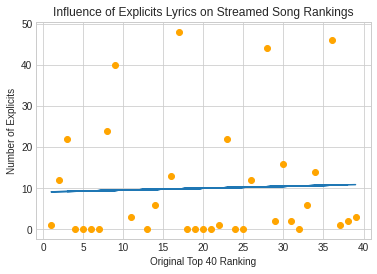

In [ ]:
#generates explicit analysis graph

x = big_df["original_rank"].tolist() 
y = big_df["explicits"].tolist()
regress = regression(x, y)
plt.style.use('seaborn-whitegrid')
plt.scatter(x, y, c = 'orange')
plt.xlabel('Original Top 40 Ranking')
plt.ylabel('Number of Explicits')
plt.plot(regress[0][0], regress[0][1])
plt.title('Influence of Explicits Lyrics on Streamed Song Rankings')
plt.show()


In [ ]:
# analyzes which songs have less than 10 explicit words

explicit_df = big_df[['song_title',"explicits"]]
explicit_df = explicit_df[explicit_df.explicits < 10]
explicit_df = explicit_df[explicit_df.explicits != 0]

In [ ]:
# gets lyrical data for songs that have less than 10 explicit words

perfect = clean_text(read_song('perfect.txt'))
dm = clean_text(read_song('dance_monkey.txt'))
intentions = clean_text(read_song('intentions.txt'))
memories = clean_text(read_song('memories.txt'))
idc = clean_text(read_song('i_dont_care_with_justin_bieber.txt'))
sayso = clean_text(read_song('say_so.txt'))
rideit = clean_text(read_song('ride_it.txt'))
savagel = clean_text(read_song('savage_love_laxed_siren_beat.txt'))
death = clean_text(read_song('death_bed_coffee_for_your_head.txt'))
badguy = clean_text(read_song('bad_guy.txt'))
rain = clean_text(read_song('rain.txt'))
rover = clean_text(read_song('rover_feat_dtg.txt'))

In [ ]:
def explicit(lyrics, word_list):
  """ Takes lyrics of a song and returns a list of all words in the lyrics that appear in the word_list """
  explicit_words = []
  final_list = []
  exp = re.compile(r"(?=("+'|'.join(word_list)+r"))")
  for phrase in lyrics:
      bad = exp.findall(phrase)
      if len(bad) != 0:
        explicit_words.append(bad)
  flat_list = [item for sublist in explicit_words for item in sublist]
  return flat_list

In [ ]:
def ex_word_count(ex_words):
  """ takes the list of desired words from lyrics and counts the occurance of each word. returns a list of tuples """
  wordfreq = []
  for w in ex_words:
    wordfreq.append(ex_words.count(w))
  merged_list = [(ex_words[i], wordfreq[i]) for i in range(0, len(ex_words))]
  merged_list = [t for t in (set(tuple(i) for i in merged_list))]
  return (merged_list)

Text(0.5, 1.0, 'Number of Explicit Word Occurances in Top 40 Streamed Songs with < 10 Explicit Lyrics')

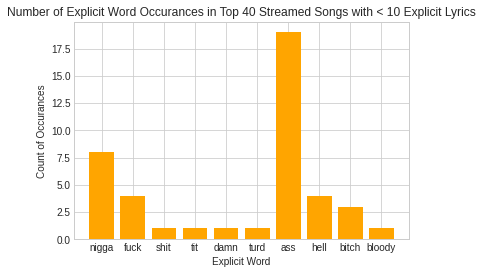

In [ ]:
# adds the explicits from all songs with > 10 explicits to a list
all = []

perfect_e = explicit(perfect, explicits)
dm_e = explicit(dm, explicits)
intentions_e = explicit(intentions, explicits)
memories_e = explicit(memories, explicits)
idc_e = explicit(idc, explicits)
sayso_e = explicit(sayso, explicits)
rideit_e = explicit(rideit, explicits)
savagel_e = explicit(savagel, explicits)
death_e = explicit(death, explicits)
badguy_e = explicit(badguy, explicits)
rain_e = explicit(rain, explicits)
rover_e = explicit(rover, explicits)

all.append(perfect_e)
all.append(dm_e)
all.append(intentions_e)
all.append(memories_e)
all.append(idc_e)
all.append(sayso_e)
all.append(rideit_e)
all.append(savagel_e)
all.append(death_e)
all.append(badguy_e)
all.append(rain_e)
all.append(rover_e)
all = [item for sublist in all for item in sublist]

# splits the tuples in the list
x,y = zip(*ex_word_count(all))

# plots the explicits and their counts
plt.bar(x,y, color = 'orange')
plt.xlabel('Explicit Word')
plt.ylabel('Count of Occurances')
plt.title('Number of Explicit Word Occurances in Top 40 Streamed Songs with < 10 Explicit Lyrics')


In [ ]:
def cloud_generator(song, subplot, title):
  """ Generates WordCloud with music note as mask for inputted list """
  lyrics = (' ').join(song)
  MASK = imageio.imread('/content/drive/My Drive/DS2500 Project/music_note.png')
  generate_cloud = wc.WordCloud(width=1000, height=1000, mask=MASK, background_color='white')

  cloud = generate_cloud.generate(lyrics)

  fig = plt.figure(figsize=(10,5), dpi=200)

  fig.add_subplot(subplot)
  plt.title(title)
  plt.axis('off')
  plt.imshow(cloud)

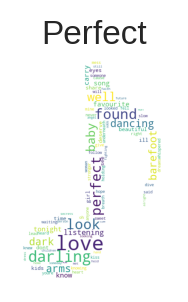

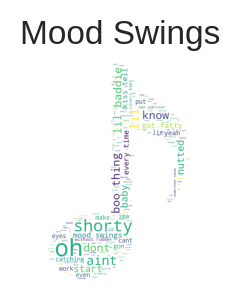

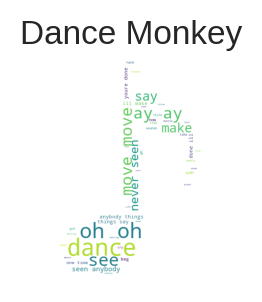

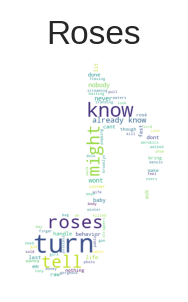

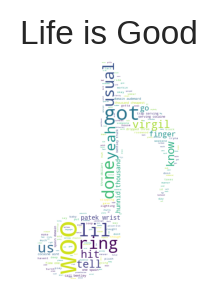

In [ ]:
# Top 1 Ranked Song -- Perfect
cloud_generator(no_stop_no_explicits['perfect'], 331, "Perfect")

# Top 2 Ranked Song -- Mood Swings
cloud_generator(no_stop_no_explicits['mood swings feat lil tjay'], 332, "Mood Swings")

# Top 3 Ranked Song -- Dance Monkey
cloud_generator(no_stop_no_explicits['dance monkey'], 333, "Dance Monkey")

# Top 4 Ranked Song -- Roses
cloud_generator(no_stop_no_explicits['roses'], 334, "Roses")

# Top 5 Ranked Song -- Life is Good
cloud_generator(no_stop_no_explicits['life is good feat drake'], 335, "Life is Good")

In [ ]:
# scoring the top 5 ranked songs for the KDE graph below

top5 = ['perfect', 'mood swings feat lil tjay', 'dance monkey', 'roses', 'life is good feat drake']

scored_songs = []

for song in top5:
  scored_songs.append(score_songs(no_stopwords[song]))

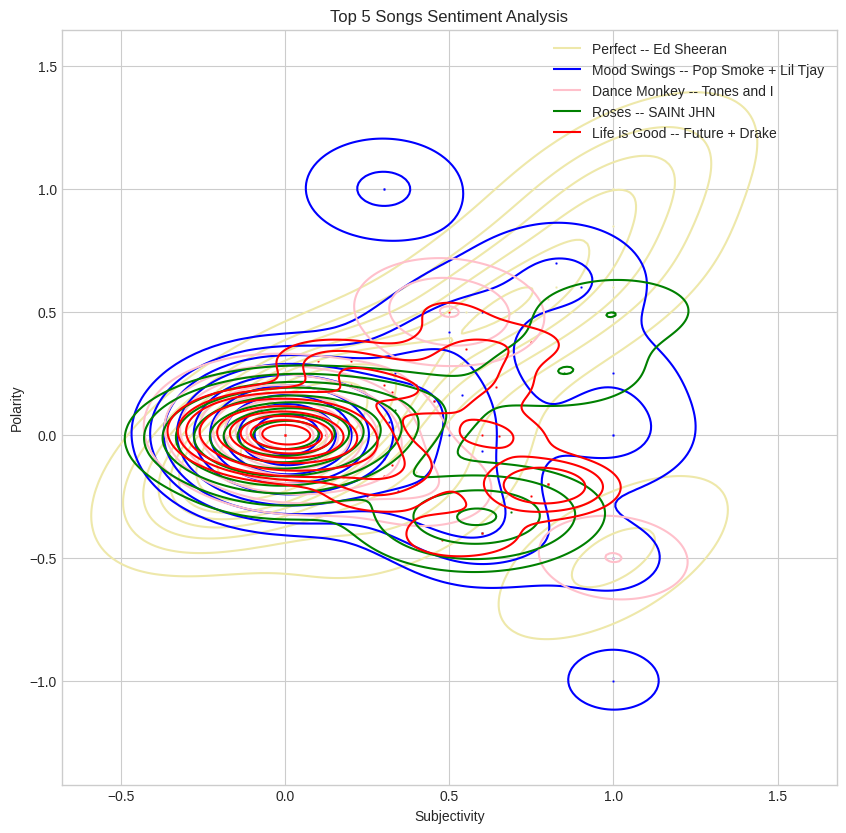

In [ ]:
# generates sentiment analysis graph for top 5 ranked songs based on attributes

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Top 5 Songs Sentiment Analysis')

def polarity_vs_subjectivity(scored_lyrics, DATA_COLOR, LINE_COLOR, LABEL):
  """ Generates polarity and subjectivity KDE plot with each song color-coded onto the plot """

  scores = scored_lyrics.values()
  polarity = [x[0] for x in scores]
  subjectivity = [x[1] for x in scores]
    
  sns.scatterplot(x=subjectivity, y=polarity, s=3, color=DATA_COLOR)
  sns.kdeplot(x=subjectivity, y=polarity, color=LINE_COLOR, label=LABEL)

polarity_vs_subjectivity(scored_songs[0], 'palegoldenrod', 'palegoldenrod', 'Perfect -- Ed Sheeran')
polarity_vs_subjectivity(scored_songs[1], 'blue', 'blue', 'Mood Swings -- Pop Smoke + Lil Tjay')
polarity_vs_subjectivity(scored_songs[2], 'pink', 'pink', 'Dance Monkey -- Tones and I')
polarity_vs_subjectivity(scored_songs[3], 'green', 'green', 'Roses -- SAINt JHN')
polarity_vs_subjectivity(scored_songs[4], 'red', 'red', 'Life is Good -- Future + Drake')
plt.legend()

In [ ]:
# scoring the bottom 5 ranked songs for the KDE graph below

bottom5 = ['head heart feat mnek', 'toosie slide', 'baby shark', 'bad guy', 'everything i wanted']

scored_songs = []

for song in bottom5:
  scored_songs.append(score_songs(no_stopwords[song]))

/usr/local/lib/python3.7/dist-packages/scipy/stats/kde.py:263: RuntimeWarning: divide by zero encountered in true_divide
  result = result / self._norm_factor
/usr/local/lib/python3.7/dist-packages/scipy/stats/kde.py:263: RuntimeWarning: invalid value encountered in true_divide
  result = result / self._norm_factor
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  **contour_kws,


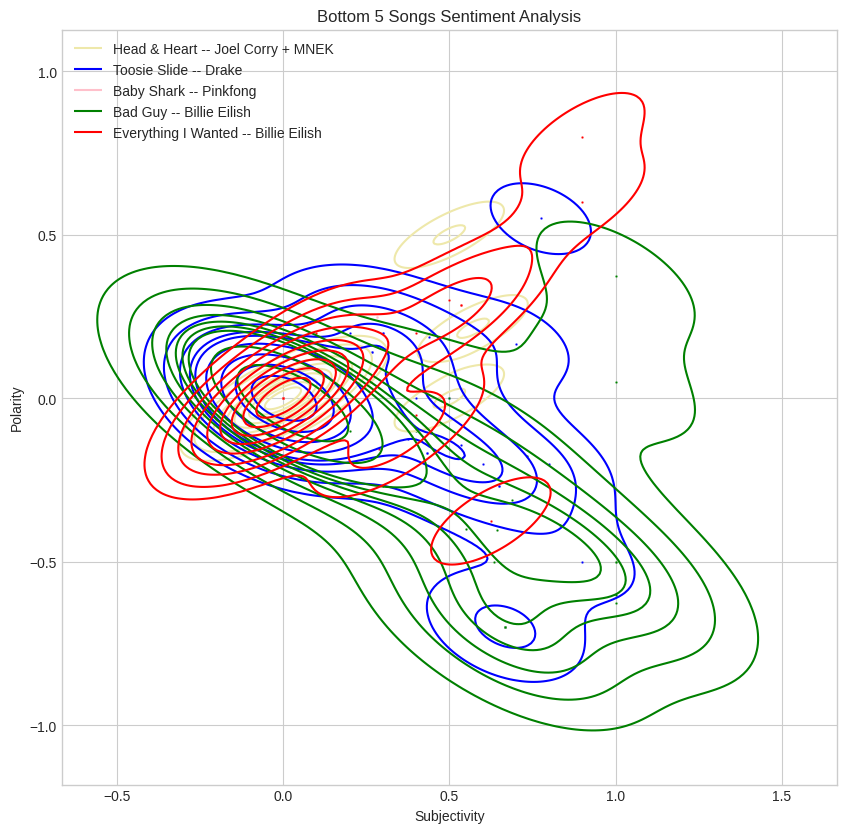

In [ ]:
# generates sentiment analysis graph for bottom 5 ranked songs based on attributes

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.title('Bottom 5 Songs Sentiment Analysis')

polarity_vs_subjectivity(scored_songs[0], 'palegoldenrod', 'palegoldenrod', 'Head & Heart -- Joel Corry + MNEK')
polarity_vs_subjectivity(scored_songs[1], 'blue', 'blue', 'Toosie Slide -- Drake')
polarity_vs_subjectivity(scored_songs[2], 'pink', 'pink', 'Baby Shark -- Pinkfong')
polarity_vs_subjectivity(scored_songs[3], 'green', 'green', 'Bad Guy -- Billie Eilish')
polarity_vs_subjectivity(scored_songs[4], 'red', 'red', 'Everything I Wanted -- Billie Eilish')
plt.legend()


In [ ]:
def comparing_most_common(clean_text1, clean_text2):
    """ Inputs two texts as lists of strings and 
    outputs a tuple with the percentage of common words between the two songs and the list of the common words """
    
    string_text1 = ' '.join(clean_text1)
    string_text2 = ' '.join(clean_text2)
    
    words1 = string_text1.split(' ')
    words2 = string_text2.split(' ')
    
    words1_counted = Counter(words1)
    words2_counted = Counter(words2)
    
    same_words = []
    
    for i in words1_counted:
        if len(i) >= 1:
            if i in words2_counted:
                same_words.append(i)
    
    percent_same_words_song1 = len(same_words) / len(words1_counted)
    
    return (percent_same_words_song1, same_words)

In [ ]:
def get_song_community(lyrics_dict):
    """ Returns list of lists where each list includes the two songs compared 
    and the number of common words """
    
    lyric_community = []

    for outer_song in lyrics_dict:
        for inner_song in lyrics_dict:
            song_compare = [outer_song,inner_song,
                comparing_most_common(
                    lyrics_dict.get(outer_song), lyrics_dict.get(inner_song)
                )[0]]
            lyric_community.append(song_compare)
    return lyric_community
            
lyric_community = get_song_community(no_stopwords)

common_word_df = pd.DataFrame(data=lyric_community, columns=['song_1', 'song_2', 'percent_common'])

Text(0.5, 1.0, 'Comparison of Shared Lyrics Between Top 40 Streamed Songs of 2020')

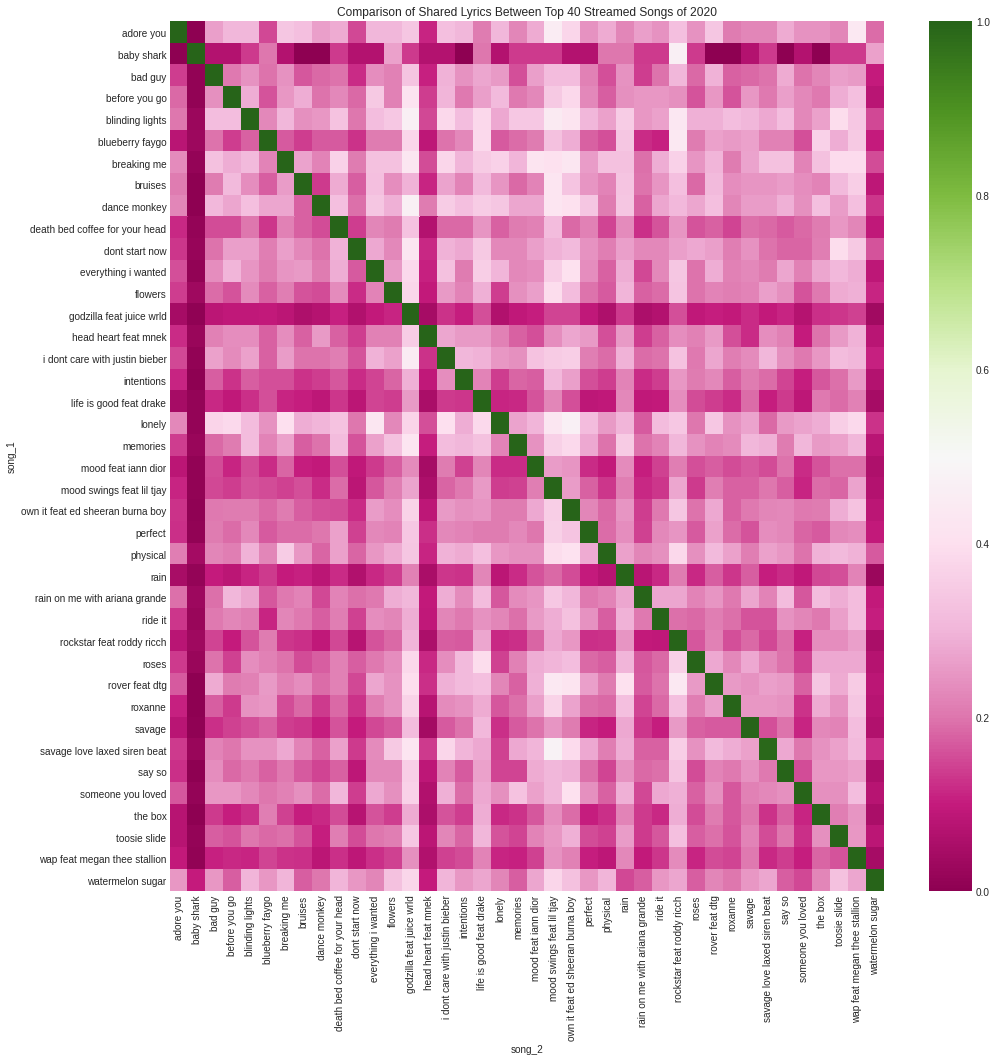

In [ ]:
heat_map = common_word_df.pivot_table('percent_common', index='song_1', columns='song_2')
plt.figure(figsize = (16,16))
sns.heatmap(heat_map, cmap='PiYG', xticklabels=True, yticklabels=True)
plt.title('Comparison of Shared Lyrics Between Top 40 Streamed Songs of 2020')

In [ ]:
avg_song_line = {song: avg_line_length(cleaned_lyrics.get(song)) for song in cleaned_lyrics}

line_length_df = pd.DataFrame.from_dict(avg_song_line, orient='index', columns=['avg_line_length'])
line_length_df = line_length_df.reset_index()
line_length_df = line_length_df.rename(columns = {'index' : 'song'})

Text(0, 0.5, 'Average Number of Words per Line')

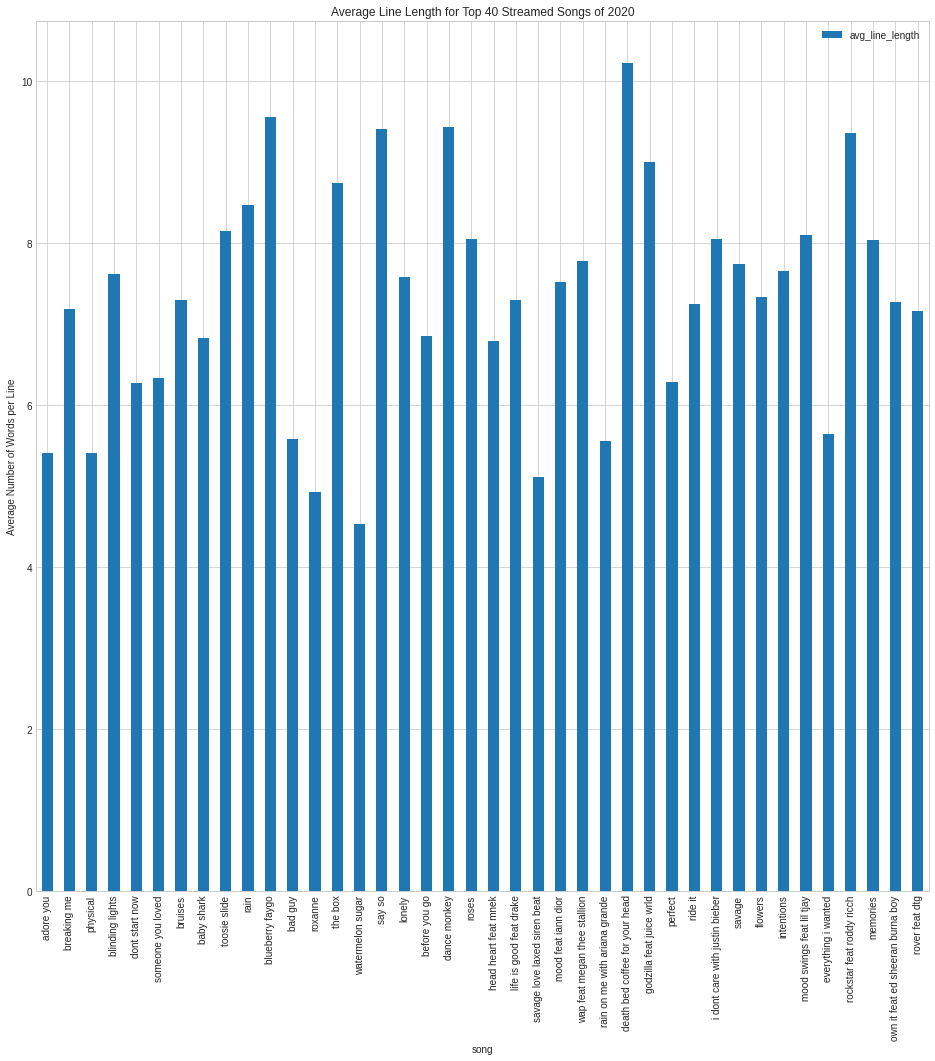

In [ ]:
ax = line_length_df.plot(figsize=(16,16), kind='bar',x='song',y='avg_line_length', title='Average Line Length for Top 40 Streamed Songs of 2020')
ax.set_ylabel('Average Number of Words per Line')

7.0 12.25 16.77777777777778


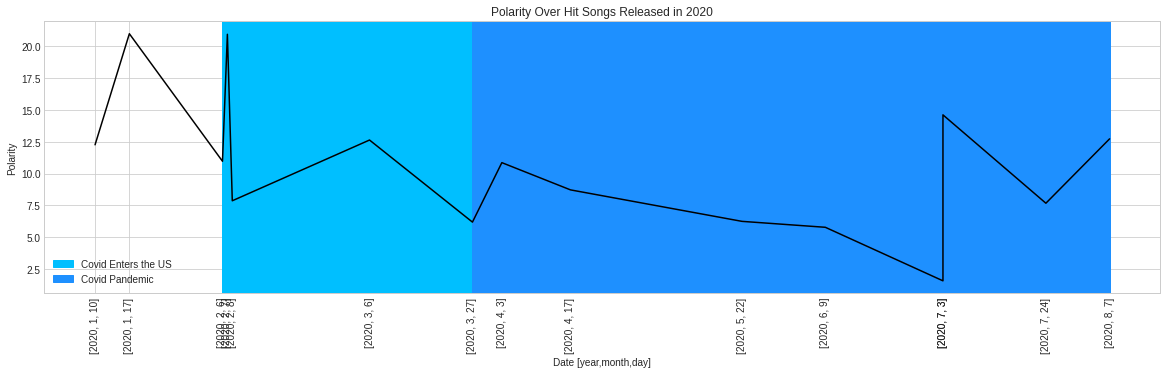

In [347]:
def organize_dates(df, column):
  '''Change format of the release date column so that it can be sorted'''
  dates = []
  series = df[column]
  for index, values in series.items():
    v = values.split('-')
    dates.append(list(map(int,v)))
  return dates

def dates_scale(column, df):
  """scale a dates stored as a list [year, month, day], and outputs its distance relative to the earliest date in the column"""
  #look at
  days_since_origin = []
  origin = df[column][0]
  for items in df[column]:
    distance = 0
    distance += ((items[0] - origin[0]) *365)
    distance += ((items[1] - origin[1])* 30)
    distance += (items[2] - origin[2])    
    days_since_origin.append(distance)
  return days_since_origin


def time_between_release_dates(df, column):
  """Find out how much time passed between the release of each song"""
  distances = []
  series  = df[column]
  for i in range(len(series)):
    j = i-1
    if i >= 1:
      distance = series[i] - series[j]
      distances.append(distance)
    else:
      distances.append(0)
  return distances

#Filter and sort datafrane based on release date
order = organize_dates(big_df, 'release_date')
dates = big_df.copy()
dates['dates'] = order
sorted_dates = dates.sort_values(by = 'dates')
sorted_dates = sorted_dates.reset_index(drop = True)


#Create scale based on days
scale = dates_scale('dates', sorted_dates)
sorted_dates['days_since_origin'] = scale

#Find out how much time pases between releases
distances = time_between_release_dates(sorted_dates, 'days_since_origin')
sorted_dates['distance_between_releases'] = distances

#Index to only show songs from 2020
distance_target = distances[19:]


def average_per_period(lst, beginning, ending):
  """Finds out the average time between releases in a specifed period"""
  period = lst[beginning : ending]
  return (sum(period)/len(period))

#Find the average period between song releases (days), between different periods (ignores time from last of 2019 to first in 2020)
pre_covid = average_per_period(distance_target, 1, 2)
enters_us = average_per_period(distance_target, 2, 6)
pandemic = average_per_period(distance_target, 6, 16)
print(pre_covid, enters_us,pandemic)


#Plot the polarity of each song, shown in order by its release date
plt.figure(figsize = (20,5))
plt.title('Polarity Over Hit Songs Released in 2020')
plt.plot(scale[19:], sorted_dates.polarity[19:], color = 'black')
plt.xticks(scale[19:], sorted_dates.dates[19:])
plt.axvspan(scale[21], scale[32], 0, 100, color = '#00BFFF', label = 'Covid Enters the US')
plt.axvspan(scale[25], scale[33], 0, 100, color = '#1E90FF', label = 'Covid Pandemic')
plt.xticks(rotation = 90)
plt.ylabel('Polarity')
plt.xlabel('Date [year,month,day]')
plt.legend()

In [ ]:
#Lyric Generator

import random

lyrics = list(cleaned_lyrics.values())

# turn the lines into lists of words
phrases = [w for word in lyrics for w in word] # changes list of lists to one list
words = [words.split() for words in phrases]
single_words = [w for word in words for w in word]

# change to use remove words here
family_friendly = []
for words in single_words:
  if words not in explicits:
    family_friendly.append(words)

tests = []
remove = []
# groups random single letters
for w in family_friendly:
    if len(w) <= 1:
      remove.append(w)

remove.sort()


# removes single letter words from list
a_count = 0
for let in remove:
  if let == 'a':
    remove.remove(let)
  if let == 'i':
    remove.remove(let)


# removes random single letters from word list
for word in family_friendly:
  if word in remove:
    family_friendly.remove(word)



begin = random.choice(family_friendly)
end = random.choice(family_friendly)


# word (key) that comes after (values)
dictionary = {}
first_word = ''
for word in family_friendly:
    if first_word not in dictionary:
        dictionary[first_word] = []
    dictionary[first_word].append(word)
    first_word = word

ngrams = dictionary

def generate_lyric(begin, ending, ngrams):
  """ generates a random song lyric based on a random begining word, end word, and surrounding words """
    
  sentence = ""
  curr_word = random.choice(begin)
  #print(curr_word)
  while True:
      sentence += " " + curr_word
      # makes all lines shorter than 8 words
      if len(sentence) > 8:
          break
      curr_word = random.choice(ngrams[begin])
      if curr_word in begin:
        generate_lyric(curr_word, ending, ngrams)
  return sentence



# creates a single line
line = generate_lyric(begin, end, ngrams)


def repeat_function(n, function):
  """repeats the lyric line function n number of times to create a verse """
  song = []
  for i in range(n): 
    verse = generate_lyric(begin, end, ngrams)
    song.append(verse)
  return song

<BarContainer object of 2 artists>

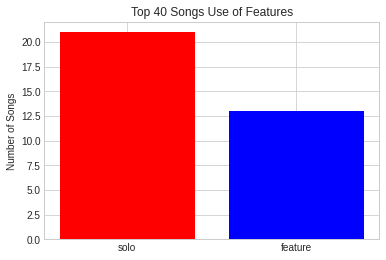

In [348]:
composition = ranking.copy()

def features_artist(df, column):
  """For each song, checks to see if there is more than one artist"""
  artist_list = df[column].to_list()
  status = []
  for items in artist_list:
    word = items.split(',')
    if len(word) >= 2:
      status.append(1)
    elif len(word) <= 1:
      status.append(0)
  return status

#Add colummn for a songs featured status"""
feature_status = features_artist(composition, 'artist_duplicate')  
composition['feature'] = feature_status

#Find how many songs had featured artists
feature_count = composition['feature'].value_counts()

solo = composition[composition.feature == 0]
featured = composition[composition.feature == 1]


#Plot Results
plt.title('Top 40 Songs Use of Features')
plt.ylabel('Number of Songs')
plt.bar(['solo','feature'],[feature_count[0], feature_count[1]], color = ['red', 'blue'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Songs with Featured Artisits
 count    13.000000
mean     19.153846
std      10.800047
min       3.000000
25%      11.000000
50%      19.000000
75%      23.000000
max      37.000000
Name: original_rank, dtype: float64
Songs without a Featured Artist
 count    21.000000
mean     20.571429
std      12.371627
min       1.000000
25%       8.000000
50%      24.000000
75%      30.000000
max      39.000000
Name: original_rank, dtype: float64


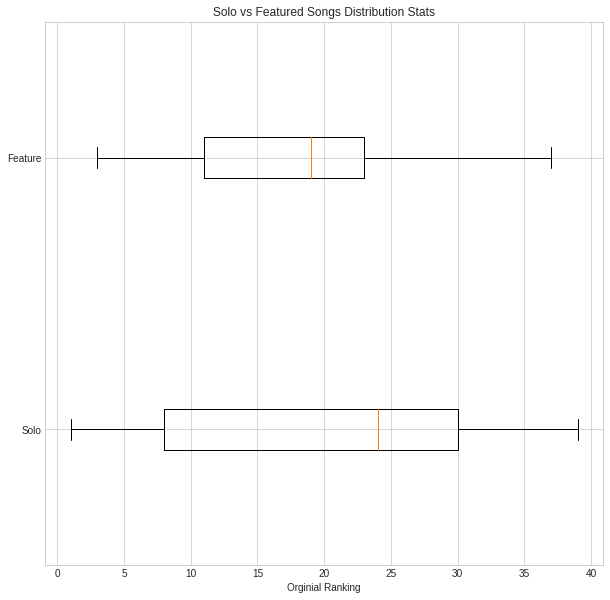

In [ ]:
plt.figure(figsize = (10,10))
plt.boxplot([solo.original_rank, featured.original_rank], vert = False, labels = ['Solo', 'Feature'])
plt.xlabel('Orginial Ranking')
plt.title('Solo vs Featured Songs Distribution Stats')


print('Songs with Featured Artisits\n' ,featured.original_rank.describe())
print('Songs without a Featured Artist\n', solo.original_rank.describe())

<class 'pandas.core.series.Series'>
R Value = 0.09851714277097408
<class 'pandas.core.series.Series'>
R Value = -0.17687315643448473
<class 'pandas.core.series.Series'>
R Value = 0.06877807461208926
<class 'pandas.core.series.Series'>
R Value = 0.211811899540341
<class 'pandas.core.series.Series'>
R Value = -0.19588524224827764


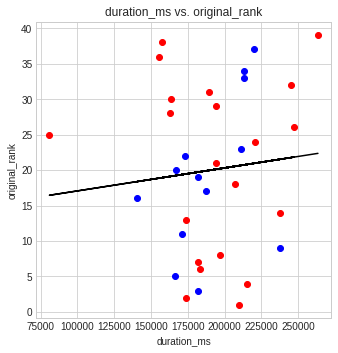

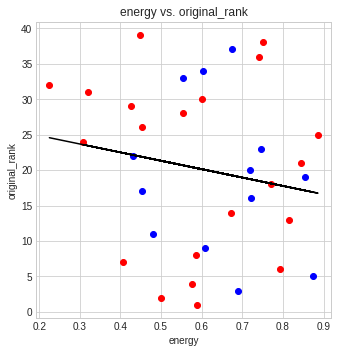

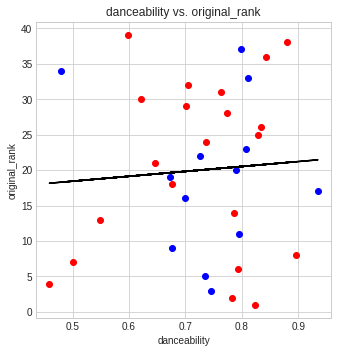

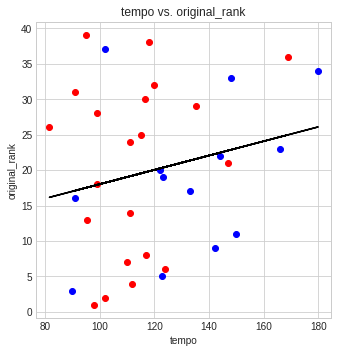

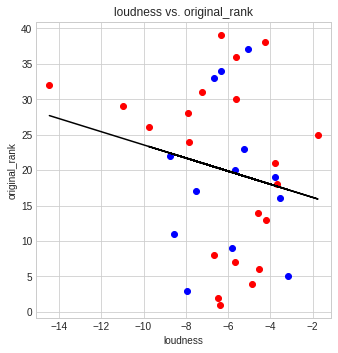

In [ ]:
categories = ['duration_ms', 'energy', 'danceability', 'tempo', 'loudness']

def comparison_scatter_plot(d1, d2, combined_df, category1, category2, d1_color, d2_color, line_color, grid_x, grid_y, subplot):
  """ Compares original rank and Spotify attribute and outputs a scatterplot comparing the two variables, including a regression line """
  fig = plt.figure(figsize = (grid_x, grid_y)) 
  fig.add_subplot(subplot)
  plt.scatter(d1[category1], d1[category2], color = d1_color, label = str(d1))
  plt.scatter(d2[category1], d2[category2], color = d2_color, label = str(d2))
  plt.title(str(category1) + " vs. " + str(category2))
  plt.xlabel(str(category1))
  plt.ylabel(str(category2))
  regress = regression(combined_df[category1], combined_df[category2])
  print('R Value =', regress[1])
  plt.plot(regress[0][0], regress[0][1], color = line_color)

comparison_scatter_plot(featured, solo, big_df, categories[0], 'original_rank', 'b', 'r', 'black', 18, 12, 231)
comparison_scatter_plot(featured, solo, big_df, categories[1], 'original_rank', 'b', 'r', 'black', 18, 12, 232)
comparison_scatter_plot(featured, solo, big_df, categories[2], 'original_rank', 'b', 'r', 'black', 18, 12, 233)
comparison_scatter_plot(featured, solo, big_df, categories[3], 'original_rank', 'b', 'r', 'black', 18, 12, 234)
comparison_scatter_plot(featured, solo, big_df, categories[4], 'original_rank', 'b', 'r', 'black', 18, 12, 235)
